In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
# !cp drive/'My Drive'/radhakrishna.tar.gz /content
!cp drive/'My Drive'/groupemotion.zip /content

In [ ]:
# !tar -xvzf radhakrishna.tar.gz
!unzip groupemotion.zip

Streaming output truncated to the last 5000 lines.
  inflating: groupemotion/Aligned/Positive/pos_3442.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3443.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3444.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3445.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3446.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3447.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3448.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3449.jpg  
  inflating: groupemotion/Aligned/Positive/pos_345 (2).jpg  
  inflating: groupemotion/Aligned/Positive/pos_345.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3450.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3451.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3452.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3453.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3454.jpg  
  inflating: groupemotion/Aligned/Positive/pos_3455.jpg  
  inflating: groupe

In [ ]:
!cd groupemotion/Aligned/ && ls

Negative  Neutral  Positive


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data Manipulation libraries
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import style
 
# Matplotlib configuration
%matplotlib inline  
style.use('fivethirtyeight')

# Keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Dropout, Flatten, Activation, Reshape, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU
from keras.utils.data_utils import get_file

# Tensorflow
import tensorflow as tf

# Image manipulation libraries
import cv2                  
from PIL import Image

# Other libraries
import random
from tqdm import tqdm
import os
import itertools

# Set seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# data
X = []
# labels
X_labels = []

# size of the image - 64x64
IMG_SIZE = 64

# assign variables for paths of each class
POSITIVE_DIR = 'groupemotion/Aligned/Positive/'
NEUTRAL_DIR = 'groupemotion/Aligned/Neutral/'
NEGATIVE_DIR = 'groupemotion/Aligned/Negative/'

In [ ]:
def generate_data_from_images(emotion_type, directory):
  # tqdm used for progress bar
  # for each image in the specified directory
  for image in tqdm(os.listdir(directory)):
    filename = os.fsdecode(image)
    if filename.endswith(".jpg"): 
      # read the colored image
      image = cv2.imread(os.path.join(directory, image))
      # resize image to 64x64
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
      
      # append the image as a numpy array to X
      X.append(np.array(image))
      # append the label to Z
      X_labels.append(emotion_type)

In [ ]:
generate_data_from_images('Positive', POSITIVE_DIR)

100%|██████████| 5724/5724 [01:00<00:00, 94.02it/s]


In [ ]:
generate_data_from_images('Neutral', NEUTRAL_DIR)

100%|██████████| 4448/4448 [00:49<00:00, 89.36it/s] 


In [ ]:
generate_data_from_images('Negative', NEGATIVE_DIR)

100%|██████████| 3987/3987 [00:45<00:00, 87.17it/s] 


In [ ]:
len(X), len(X_labels)

(14159, 14159)

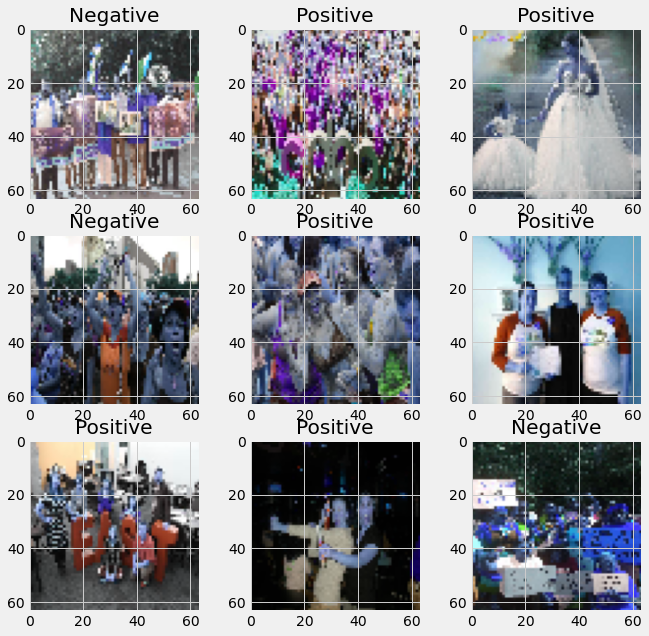

In [ ]:
cols = 3
rows = 3
fig, axis = plt.subplots(rows, cols)
fig.set_size_inches(10, 10)
for i in range(rows):
  for j in range(cols):
    image_index = random.randint(0, len(X))
    axis[i, j].imshow(X[image_index])
    axis[i, j].set_title(X_labels[image_index])

In [ ]:
# initialize the label encoder class
labelencoder = LabelEncoder()

# Convert the 3 classes "positive", "neutral" and "negative" into corresponding 
# numerical classes - 2, 1 and 0.
Y = labelencoder.fit_transform(X_labels)
# Check the classes applied by the Label Encoder
labelencoder_classes = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(labelencoder_classes)
# Apply one-hot encoding to convert the label encoded categorical data
# into multiple columns where each numerical class is replaced by 0 or 1
Y = to_categorical(Y,3)

# Convert X into a numpy array
X = np.array(X)
# Normalize all the pixel values for each image by diving by 255
X = X/255

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [ ]:
num_features = 64
num_labels = 3
batch_size = 64
epochs = 100
width, height = 64, 64

#x = np.load('./fdataX.npy')
#y = np.load('./flabels.npy')

#x -= np.mean(x, axis=0)
#x /= np.std(x, axis=0)

#for xx in range(10):
#    plt.figure(xx)
#    plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
#plt.show()

#splitting into training, validation and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save('modXtest', X_test)
np.save('modytest', Y_test)

In [ ]:
from tensorflow.keras import regularizers
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D
from keras.models import Sequential

In [ ]:
def get_cnn_model():
    model = Sequential()

    model.add(Convolution2D(64, (3, 1), padding='same', input_shape=(64,64,3)))
                                                                    
    model.add(Convolution2D(64, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 1), padding='same'))
    model.add(Convolution2D(128, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 1), padding='same'))
    model.add(Convolution2D(256, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 1), padding='same'))
    model.add(Convolution2D(512, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(3))
    model.add(Activation('softmax'))
    return model

In [ ]:
cnn_model = get_cnn_model()

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        12352     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       2

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K

In [ ]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [ ]:
def train_cnn_model(model):
    filepath='../opt/ger-cnn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 100
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    test_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [ ]:
history, cnn_model = train_cnn_model(cnn_model)

Epoch 1/100
358/358 [==============================] - 19s 30ms/step - loss: 1.2289 - fbeta: 0.2428 - acc: 0.3862 - val_loss: 1.1419 - val_fbeta: 0.1618 - val_acc: 0.3785

Epoch 00001: saving model to ../opt/ger-cnn/Model.01-0.3785.hdf5

Epoch 00001: saving model to ../opt/ger-cnn/Model.01-0.3785.hdf5
Epoch 2/100
358/358 [==============================] - 10s 28ms/step - loss: 1.0818 - fbeta: 0.2257 - acc: 0.4499 - val_loss: 1.0185 - val_fbeta: 0.1708 - val_acc: 0.4908

Epoch 00002: saving model to ../opt/ger-cnn/Model.02-0.4908.hdf5

Epoch 00002: saving model to ../opt/ger-cnn/Model.02-0.4908.hdf5
Epoch 3/100
358/358 [==============================] - 10s 29ms/step - loss: 1.0450 - fbeta: 0.2531 - acc: 0.4743 - val_loss: 1.1090 - val_fbeta: 0.3243 - val_acc: 0.4230

Epoch 00003: saving model to ../opt/ger-cnn/Model.03-0.4230.hdf5

Epoch 00003: saving model to ../opt/ger-cnn/Model.03-0.4230.hdf5
Epoch 4/100
358/358 [==============================] - 10s 29ms/step - loss: 1.0238 - fbeta

In [ ]:
def eval_model(history, model):
    batch_size = 32
    score = model.evaluate(X_test, Y_test, steps=(int)(len(X_test) / batch_size))
    print('Evaluation loss: ', score[0])
    print('Evaluation accuracy: ', score[1])
    # summarize history for accuracy
    plt.plot(history.history['acc'], color='b', label='Training')
    plt.plot(history.history['val_acc'], color='g', label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color='b', label='Training')
    plt.plot(history.history['val_loss'], color='g', label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
    y_pred = model.predict_classes(X_test)
    y_true = np.asarray([np.argmax(i) for i in Y_test])

44/44 [==============================] - 1s 13ms/step - loss: 1.1134 - fbeta: 0.5517 - acc: 0.5989
Evaluation loss:  1.1134032011032104
Evaluation accuracy:  0.5517266988754272


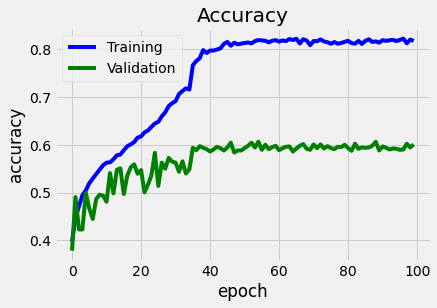

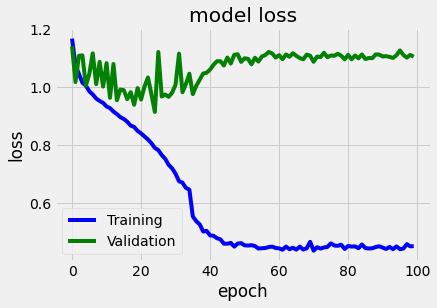

In [ ]:
eval_model(history, cnn_model)

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

NameError: ignored

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Credit: https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
    """
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure()
plot_confusion_matrix(cm, classes=labelencoder.classes_)
plt.show()

NameError: ignored